In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import linprog
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [2]:
def get_steady_state(A):
    leftPart = []
    for ind in range(1, len(A)):
        leftPart.append(np.array(A[0]) - np.array(A[ind]))
    leftPart.append(np.ones(len(A))) 

    rightPart = np.zeros(len(A))
    rightPart[len(A) - 1] = 1

    return np.linalg.solve(leftPart, rightPart)

In [3]:
def fun(s, t):
    
    global A 
    f = []
    
    for ind in range(len(A)):
        element = 0
        for i in range(len(A)):
            element += A[ind][i] * s[i]
            for j in range(len(A)):
                element -= A[i][j] * s[i] * s[j]
                
        f.append(s[ind] * element)
        
    return f

In [4]:
def linprogTask(A, u, constr, task = 'MAX'):
    global EPS
    
    # Коэффициенты в уравнении, которое оптимизируем 
    invA = np.linalg.inv(A)   
    
    c = []
    for i in range(len(A)):
        for j in range(len(A)):
            coef = 0
            for k in range(len(A)):
                coef += invA[k][i] * u[j]
            c.append(coef)
            
    # Ограничения на a_ij        
    bounds = []
    for i in range(len(A)**2):
        bounds.append((-abs(constr), abs(constr)))
        
    # Ограничения на сумму a_ij * delta a_ij   
    a = list(np.array(A).reshape(1, len(A)**2).tolist())
    b = [0]
    
    # Условия для принадлежности частот единичному симплексу
    invA_tr = invA.transpose()
    for i in range(len(A)):
        a_ = []
        a__ = []
        for m in range(len(A)):
            for j in range(len(A)):
                coef2 = 0
                coef = 0
                for k in range(len(A)):
                    coef2 += invA_tr[m][k]
                coef += u[j] * u[i]  * coef2 - invA[i][m] * u[j]
                a_.append(coef)
                a__.append(-coef)  
            
        a.append(a_)
        b.append(1 - u[i] - EPS)
        a.append(a__)
        b.append(u[i] - EPS)
   
    if task == 'MAX':
        res = linprog(np.array(c) * (-1), 
                      A_ub = a, b_ub = b, 
                      bounds = bounds, 
                      method = 'simplex')
    else:
        res = linprog(c, 
                      A_ub = a, b_ub = b, 
                      bounds = bounds, 
                      method = 'simplex')
        
    return res

In [5]:
def plot_steady_state(steadyState):
    plt.figure(figsize = (15, 10))
    
    for i in range(len(steadyState[0])):
        plt.plot(np.array(steadyState)[:, i], label = 'u' + str(i + 1))
        
    plt.legend()
    plt.xlabel(u'Номер итерации', fontsize = 16) 
    plt.ylabel(u'Частота', fontsize = 16)
    plt.title(u'Изменение неподвижной точки', fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.ylim((-0.05, 1.05))
    plt.show()

In [6]:
def plot_fitness(fitness):
    plt.figure(figsize = (15, 10))
    plt.plot(fitness, 'r', label = 'Средний фитнес в стац. состоянии')
    plt.legend()
    plt.xlabel(u'Номер итерации', fontsize = 16) 
    plt.ylabel(u'Фитнес', fontsize = 16)
    plt.title(u'Изменение среднего фитнеса', fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.show()

In [7]:
def plot_ode(u_ode, t, timeFitnessIntegral):
    n = len(u_ode) // 2 + len(u_ode) % 2 
    
    for i in range(n):
        fig, axs = plt.subplots(figsize = (20, 5), nrows = 1, ncols = 2)
        
        for j in range(len(u_ode[2 * i][0])):
            axs[0].plot(t, np.array(u_ode[2 * i])[:, j], label = 'u' + str(j + 1))
            
        axs[0].legend()
        axs[0].set_xlabel(r"$t$", fontsize = 16) 
        axs[0].set_ylabel(u'Частота', fontsize = 16)
        axs[0].set_title(u'Изменение в динамике на ' + str(timeFitnessIntegral[2 * i]) +\
                         u' итерации', fontsize = 16)
        
        plt.setp(axs[0].get_xticklabels(), fontsize = 16) 
        plt.setp(axs[0].get_yticklabels(), fontsize = 16) 
          
        if (i < n - 1) or (len(u_ode) % 2 == 0):    
            for j in range(len(u_ode[2 * i + 1][0])):
                axs[1].plot(t, np.array(u_ode[2 * i + 1])[:, j], label = 'u' + str(j + 1))



            axs[1].legend()
            axs[1].set_xlabel(r"$t$", fontsize = 16)  
            axs[1].set_ylabel(u'Частота', fontsize = 16)
            axs[1].set_title(u'Изменение в динамике на ' + str(timeFitnessIntegral[2 * i + 1]) +\
                             u' итерации', fontsize = 16)
            plt.setp(axs[1].get_xticklabels(), fontsize = 16) 
            plt.setp(axs[1].get_yticklabels(), fontsize = 16)         

    
        plt.show()

In [13]:
count_iter = 1000    # number of iterations of evolution
t1 = 10000           # final point in time to solve the ODE
point_cnt = 100      # count point for solving ODE
solve_step = 125     # ODU decision step (at which iterations of evolution we will solve an ODE)
EPS = 0.001

n = 5
constr = 0.001

row = [0] * (n - 1) + [1]
A = [list(np.roll(row, i)) for i in range(n)]

u0 = np.random.uniform(size = n)
u0 /= u0.sum()

t = np.linspace(0, t1, point_cnt)

steadyState = []
fitness = []
norma = []
u_ode = []
timeFitnessIntegral = []

# At each next step, we again find the frequencies and fitness, solve the LPP and get a new matrix A 
for i in tqdm(range(count_iter + 1)):
    
    steadyState.append(get_steady_state(A))                                # Calculated steady state   
    fitness.append(np.dot(np.dot(A, steadyState[i]), steadyState[i]))      # Calculated fitness in steady state
    norma.append(sum(sum(np.array(A) * np.array(A))))                      # Calculated matrix norm

    if (i == 0) or (i == count_iter) or (i % solve_step == 0):
        u_ode.append(odeint(fun, u0, t))                                   # Calculated ODE
        timeFitnessIntegral.append(i)
        
    res = linprogTask(A, steadyState[-1], constr, task = 'MAX')            # Calculated LPP
    A = (np.array(A).reshape(1, len(A)**2) + res.x).reshape(len(A), len(A))


100%|████████████████████████████████████████████| 1001/1001 [01:33<00:00, 10.71it/s]


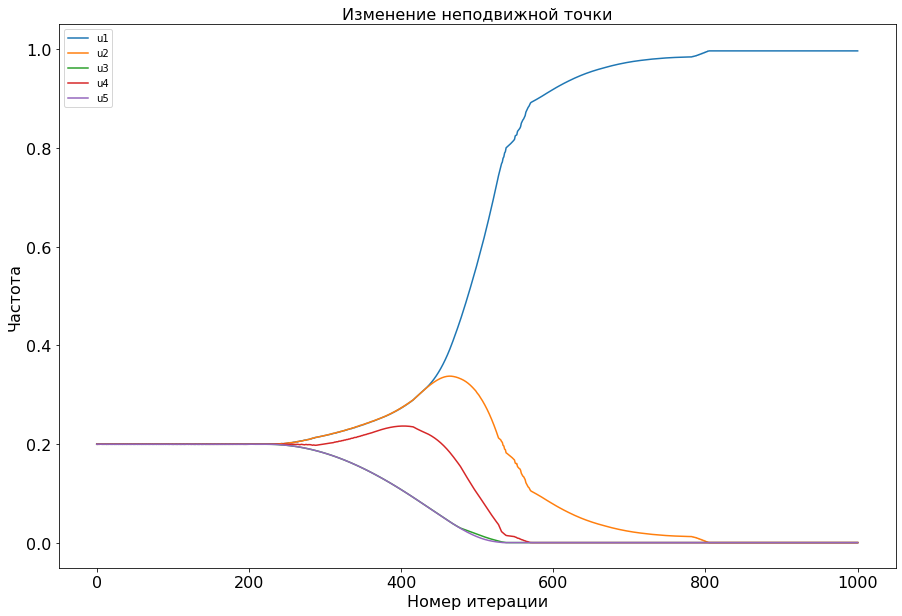

In [14]:
plot_steady_state(steadyState)

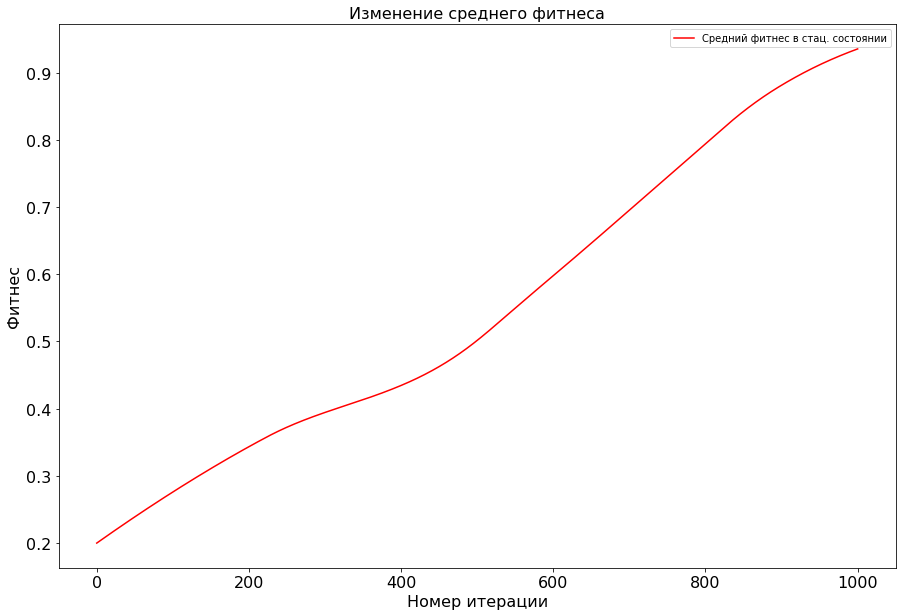

In [15]:
plot_fitness(fitness)

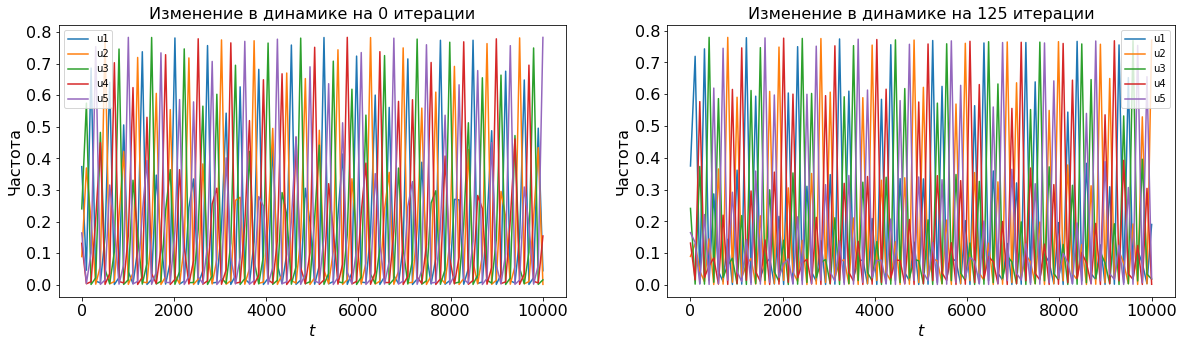

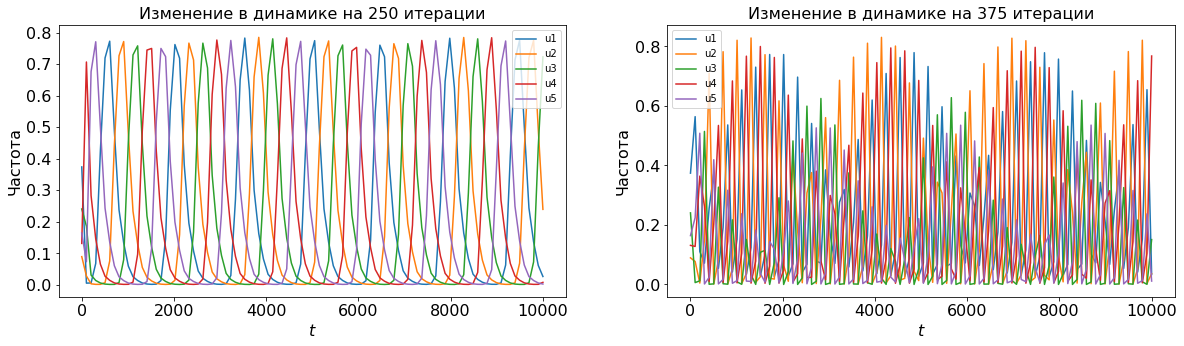

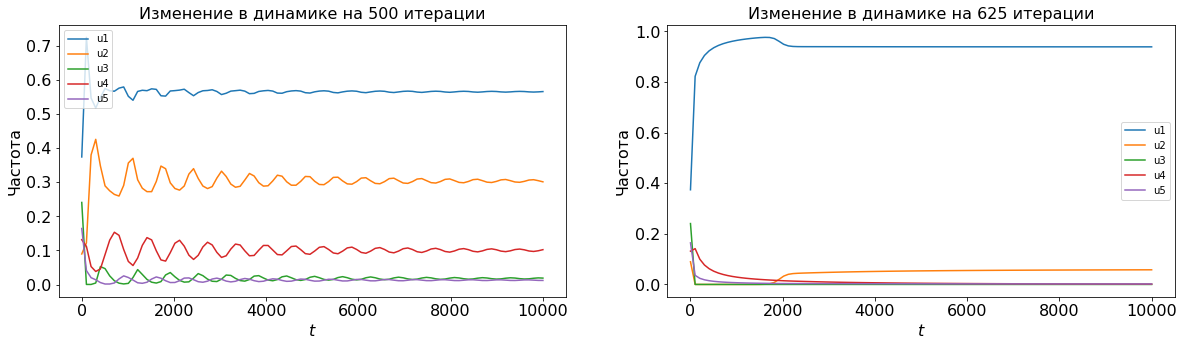

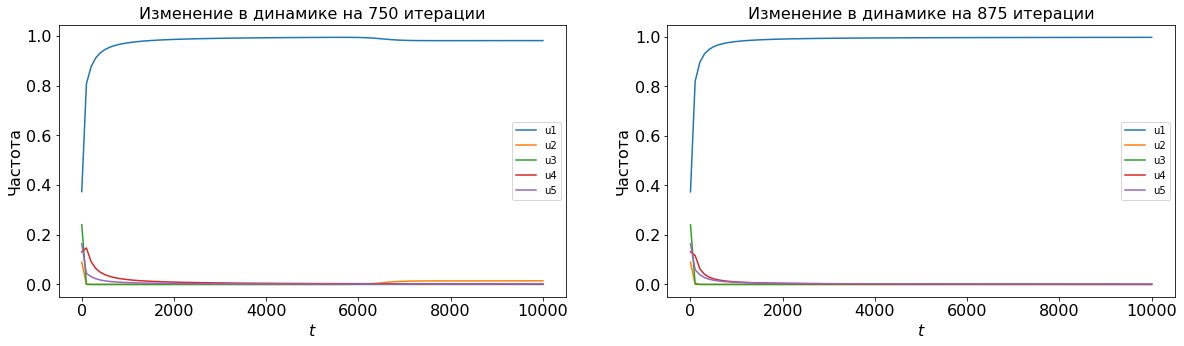

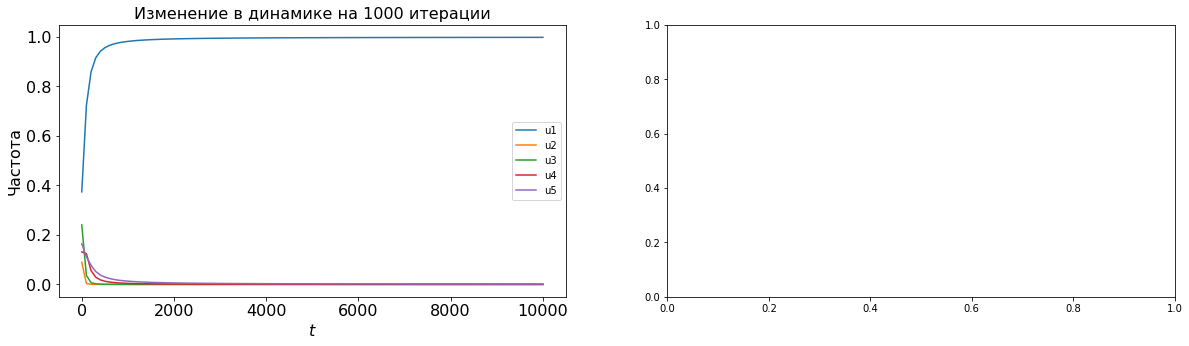

In [16]:
plot_ode(u_ode, t, timeFitnessIntegral)